<a href="https://colab.research.google.com/github/alex433741/FInal-Project/blob/main/NBA_Player_Stats_Predicting_Project.Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS 3120 Final Project: Predicting Nikola Jokic stats for future games

For this project I am going to be using data from "Basketball-Refrence.com". The excat data I am using is his 23-24 season stats and all the games up to today 11/21/2024. I exported the two files and put them in an excel sheet that I will upload into this workbook.

For this project I plan to use and test different models like linear regression, GradientBoosting, and neural networks. For missing data I plan to completly remove the rows that are empty since it is games were the player was inactive. I also plan to remove the columns for 3P% and FT%. This is because there are instances were the values are empty because the player didnt attempt a FT or a 3P. But in the columns for FTA and 3PA it will show a 0 since none were attempted. But the percantege for them will be empty and it should not be 0 or any other value.

For measuring the performance of my models I will be using RMSE





In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Jokic_Stats_Machine_Learning_Project.xlsx to Jokic_Stats_Machine_Learning_Project.xlsx


In [250]:
# Loading the  excel file into a data frame
df = pd.read_excel('Jokic_Stats_Machine_Learning_Project.xlsx')

# Print the shape of the df and first 5 rows of raw data
print(f"** df has {df.shape[0]} rows and {df.shape[1]} columns **")
df.head()


** df has 99 rows and 31 columns **


,Rk,G,Date,Age,Tm,Home/Away,Opp,Result,PD,GS,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1.0,2023-10-24,28-247,DEN,Home,LAL,W,(+12),1,...,10.0,13.0,11.0,1.0,1.0,2.0,2.0,29.0,29.3,15.0
1,2,2.0,2023-10-27,28-250,DEN,Away,MEM,W,(+4),1,...,9.0,12.0,7.0,1.0,1.0,9.0,1.0,22.0,17.0,6.0
2,3,3.0,2023-10-29,28-252,DEN,Away,OKC,W,(+33),1,...,12.0,14.0,5.0,0.0,0.0,4.0,3.0,28.0,24.9,21.0
3,4,4.0,2023-10-30,28-253,DEN,Home,UTA,W,(+8),1,...,9.0,10.0,11.0,0.0,2.0,1.0,3.0,27.0,29.7,13.0
4,5,5.0,2023-11-01,28-255,DEN,Away,MIN,L,(-21),1,...,8.0,10.0,3.0,0.0,0.0,5.0,0.0,25.0,14.2,-19.0


In [251]:
# One-hot encoding Home/Away column
# Select the 'Home/Away' column
Home_Away = df['Home/Away']

# Apply one-hot encoding
Home_Away_encoded = pd.get_dummies(Home_Away).astype(int)

# Add the one-hot encoded DataFrame to your main DataFrame
df = pd.concat([df, Home_Away_encoded], axis=1)

In [252]:
# One-hot encoding result column
# Select the result column
Result = df['Result']

# Apply one-hot encoding
Result_encoded = pd.get_dummies(Result).astype(int)

# Add the one-hot encoded DataFrame to your main DataFrame
df = pd.concat([df, Result_encoded], axis=1)

In [253]:
# get a list of the column names that are either integers or floats
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics).copy()
numeric_df.describe()

,Rk,G,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,TOV,PF,PTS,GmSc,+/-,Away,Home,L,L,W
count,99.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,79.000000,93.000000,93.000000,...,93.000000,93.000000,93.000000,93.000000,93.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,50.000000,47.000000,10.505376,18.107527,0.596527,1.225806,3.107527,0.448177,4.655914,5.677419,...,3.096774,2.354839,26.892473,27.366667,8.870968,0.494949,0.505051,0.313131,0.010101,0.676768
std,28.722813,26.990739,3.360977,5.881922,0.149009,1.171482,2.460392,0.329502,3.201544,3.680623,...,1.888550,1.203664,8.048038,8.276319,13.617624,0.502519,0.502519,0.466127,0.100504,0.470091
min,1.000000,1.000000,2.000000,3.000000,0.281000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.000000,9.000000,-23.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.500000,24.000000,8.000000,14.000000,0.500000,0.000000,1.000000,0.200000,2.000000,3.000000,...,2.000000,1.000000,23.000000,21.800000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,47.000000,11.000000,18.000000,0.579000,1.000000,3.000000,0.375000,4.000000,5.000000,...,3.000000,2.000000,27.000000,28.200000,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,74.500000,70.000000,13.000000,22.000000,0.684000,2.000000,5.000000,0.667000,6.000000,7.000000,...,4.000000,3.000000,32.000000,32.800000,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,99.000000,93.000000,18.000000,32.000000,1.000000,7.000000,12.000000,1.000000,18.000000,18.000000,...,9.000000,6.000000,42.000000,46.600000,39.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [254]:
print(numeric_df.head())

   Rk    G    FG   FGA    FG%   3P  3PA    3P%   FT  FTA  ...  TOV   PF   PTS  \
0   1  1.0  12.0  22.0  0.545  3.0  5.0  0.600  2.0  4.0  ...  2.0  2.0  29.0   
1   2  2.0   8.0  14.0  0.571  1.0  4.0  0.250  5.0  6.0  ...  9.0  1.0  22.0   
2   3  3.0  12.0  16.0  0.750  1.0  2.0  0.500  3.0  3.0  ...  4.0  3.0  28.0   
3   4  4.0  12.0  16.0  0.750  1.0  3.0  0.333  2.0  5.0  ...  1.0  3.0  27.0   
4   5  5.0  11.0  23.0  0.478  1.0  6.0  0.167  2.0  2.0  ...  5.0  0.0  25.0   

   GmSc   +/-  Away  Home  L  L   W  
0  29.3  15.0     0     1  0   0  1  
1  17.0   6.0     1     0  0   0  1  
2  24.9  21.0     1     0  0   0  1  
3  29.7  13.0     0     1  0   0  1  
4  14.2 -19.0     1     0  1   0  0  

[5 rows x 27 columns]


In [255]:
# See which rows in numeric_df have more than 20 missing values meaning player was inactive
missing = numeric_df.isnull().sum(axis=1)
missing = missing[missing > 20]
print(missing)

17    21
48    21
70    21
92    21
93    21
94    21
dtype: int64


In [256]:
# Remove these rows from the DataFrame
nrows_before = numeric_df.shape[0]
numeric_df = numeric_df.drop(index=missing.index)
nrows_after = numeric_df.shape[0]
print(f"** Removed {nrows_before - nrows_after} rows **")

** Removed 6 rows **


In [257]:
# See which columns in numeric_df has missing values
missing = numeric_df.isnull().sum()
missing = missing[missing > 0]
print(missing)


3P%    14
FT%     4
dtype: int64


In [258]:
# Remove these columns from the DataFrame
ncols_before = numeric_df.shape[1]
numeric_df = numeric_df.drop(columns=missing.index)
ncols_after = numeric_df.shape[1]
print(f"** Removed {ncols_before - ncols_after} columns **")

** Removed 2 columns **


In [243]:
# Feature engineering
# Adding rolling avg
# numeric_df['avg_points_last_5'] = numeric_df['PTS'].rolling(window=5).mean().reset_index(0, drop=True)
# numeric_df['avg_assist_last_5'] = numeric_df['AST'].rolling(window=5).mean().reset_index(0, drop=True)
# numeric_df['avg_rebounds_last_5'] = numeric_df['TRB'].rolling(window=5).mean().reset_index(0, drop=True)
# numeric_df['avg_FG_last_5'] = numeric_df['FG'].rolling(window=5).mean().reset_index(0, drop=True)
# numeric_df['avg_FGA_last_5'] = numeric_df['FGA'].rolling(window=5).mean().reset_index(0, drop=True)

In [259]:
numeric_df.head()

,Rk,G,FG,FGA,FG%,3P,3PA,FT,FTA,ORB,...,TOV,PF,PTS,GmSc,+/-,Away,Home,L,L,W
0,1,1.0,12.0,22.0,0.545,3.0,5.0,2.0,4.0,3.0,...,2.0,2.0,29.0,29.3,15.0,0,1,0,0,1
1,2,2.0,8.0,14.0,0.571,1.0,4.0,5.0,6.0,3.0,...,9.0,1.0,22.0,17.0,6.0,1,0,0,0,1
2,3,3.0,12.0,16.0,0.750,1.0,2.0,3.0,3.0,2.0,...,4.0,3.0,28.0,24.9,21.0,1,0,0,0,1
3,4,4.0,12.0,16.0,0.750,1.0,3.0,2.0,5.0,1.0,...,1.0,3.0,27.0,29.7,13.0,0,1,0,0,1
4,5,5.0,11.0,23.0,0.478,1.0,6.0,2.0,2.0,2.0,...,5.0,0.0,25.0,14.2,-19.0,1,0,1,0,0


In [260]:
X = numeric_df.drop(columns=['Rk', 'PTS', 'G']).copy() # remove the index Id and outcome SalePrice
y = numeric_df['PTS'].copy()

In [261]:
print(X.shape)
print(y.shape)

(93, 22)
(93,)


In [262]:
# Sort the columns of X according to how strong their correlation is with PTS
correlations = X.corrwith(y).abs().sort_values(ascending=False)
X = X[correlations.index]
X.head()

,FG,GmSc,FGA,3P,FTA,FT,3PA,ORB,TRB,FG%,...,L,BLK,+/-,L,TOV,W,Away,Home,PF,AST
0,12.0,29.3,22.0,3.0,4.0,2.0,5.0,3.0,13.0,0.545,...,0,1.0,15.0,0,2.0,1,0,1,2.0,11.0
1,8.0,17.0,14.0,1.0,6.0,5.0,4.0,3.0,12.0,0.571,...,0,1.0,6.0,0,9.0,1,1,0,1.0,7.0
2,12.0,24.9,16.0,1.0,3.0,3.0,2.0,2.0,14.0,0.750,...,0,0.0,21.0,0,4.0,1,1,0,3.0,5.0
3,12.0,29.7,16.0,1.0,5.0,2.0,3.0,1.0,10.0,0.750,...,0,2.0,13.0,0,1.0,1,0,1,3.0,11.0
4,11.0,14.2,23.0,1.0,2.0,2.0,6.0,2.0,10.0,0.478,...,0,0.0,-19.0,1,5.0,0,1,0,0.0,3.0


In [263]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [264]:
# Fit a regression model to the data using X to predict y
model_ls = LinearRegression()
num_features = X.shape[1]

rmse_values_ls = []
pred_rmse_values_ls = []
min_features = 1
for i in range(min_features, num_features + 1):
    model_ls.fit(X_train.iloc[:,0:i], y_train)
    mse = np.sqrt(np.mean((y_train - model_ls.predict(X_train.iloc[:,0:i]))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_ls.predict(X_test.iloc[:,0:i]))**2))
    rmse_values_ls.append(mse)
    pred_rmse_values_ls.append(pred_mse)

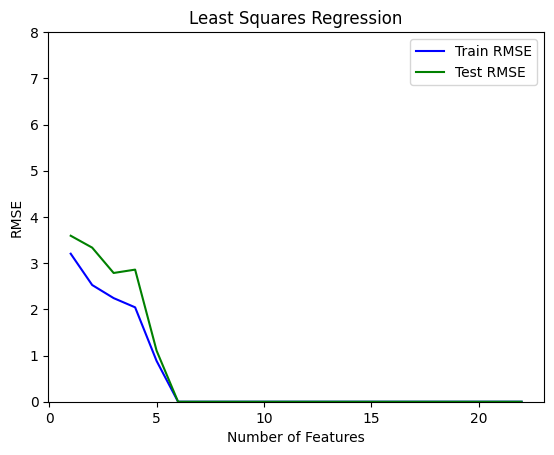

In [265]:
# Plot the rmse values
plt.plot(range(min_features, num_features + 1), rmse_values_ls, label='Train RMSE', color='blue')
plt.plot(range(min_features, num_features + 1), pred_rmse_values_ls, label='Test RMSE', color='green')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.ylim(0, 8)
plt.title('Least Squares Regression')
plt.legend()
plt.show()

In [268]:
# Decision Tree Regression
rmse_values_dt = []
pred_rmse_values_dt = []
max_depths = range(1, 50)
for i in range(len(max_depths)):
    model_dt = DecisionTreeRegressor(max_depth=max_depths[i])
    model_dt.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_dt.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_dt.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

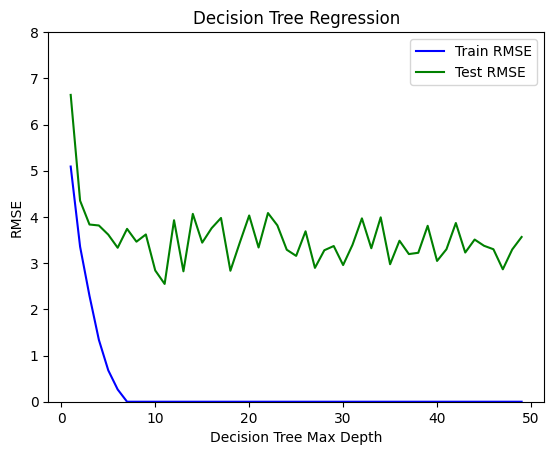

In [269]:
# Plot the rmse values
plt.plot(range(min(max_depths), max(max_depths)+1), rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(range(min(max_depths), max(max_depths)+1), pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Decision Tree Max Depth')
plt.ylabel('RMSE')
plt.title('Decision Tree Regression')
plt.ylim(0, 8)
plt.legend()
plt.show()

In [272]:
# Random Forest Model Tuning
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 102, 5))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_rf = RandomForestRegressor(n_estimators=poss_num_estimators[i], min_samples_leaf=1, random_state=2)
    model_rf.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_rf.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_rf.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

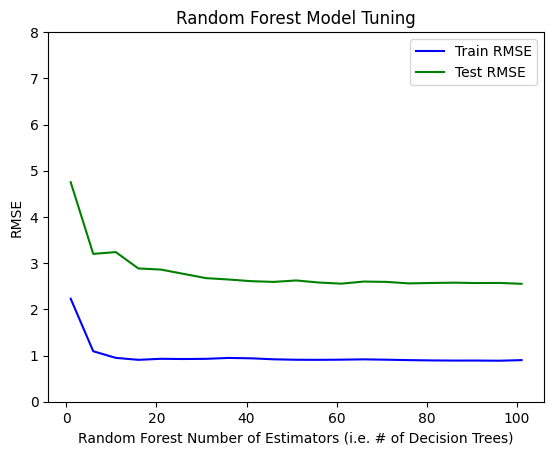

In [273]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Random Forest Number of Estimators (i.e. # of Decision Trees)')
plt.ylabel('RMSE')
plt.title('Random Forest Model Tuning')
plt.ylim(0, 8)
plt.legend()
plt.show()

In [274]:
# Gradient Boosting Regressor
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 402, 10))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_gb = GradientBoostingRegressor(n_estimators=poss_num_estimators[i], learning_rate=0.1, random_state=2)
    model_gb.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_gb.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_gb.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

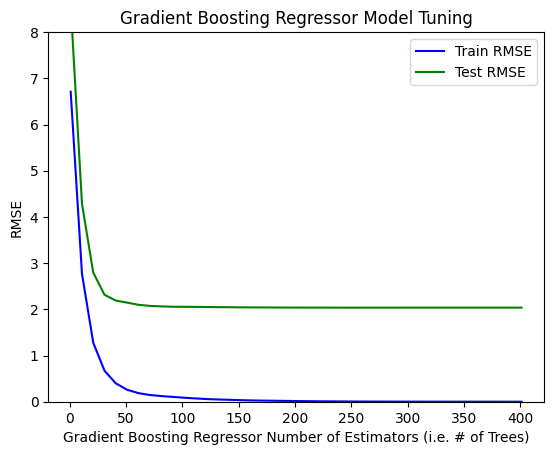

In [275]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Gradient Boosting Regressor Number of Estimators (i.e. # of Trees)')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Regressor Model Tuning')
plt.ylim(0, 8)
plt.legend()
plt.show()

In [276]:
# set k to be the number of folds for cross-validation (i.e. the number of different test dataset we'll use)
k = 10

In [277]:
model_ls = LinearRegression()
scores_ls = cross_val_score(model_ls, X.iloc[:,:30], y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_ls.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_ls.var()):1.2E} **")

** Average R2 = 1.00E+00 **
** R2 SD = 0.00E+00 **


In [278]:
model_dt = DecisionTreeRegressor(max_depth=20, random_state=2)
scores_dt = cross_val_score(model_dt, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_dt.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_dt.var()):1.2E} **")

** Average R2 = 6.40E-01 **
** R2 SD = 2.37E-01 **


In [279]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=2)
scores_rf = cross_val_score(model_rf, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_rf.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_rf.var()):1.2E} **")

** Average R2 = 8.74E-01 **
** R2 SD = 5.91E-02 **


In [280]:
model_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=2)
scores_gb = cross_val_score(model_gb, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_gb.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_gb.var()):1.2E} **")

** Average R2 = 9.18E-01 **
** R2 SD = 4.73E-02 **


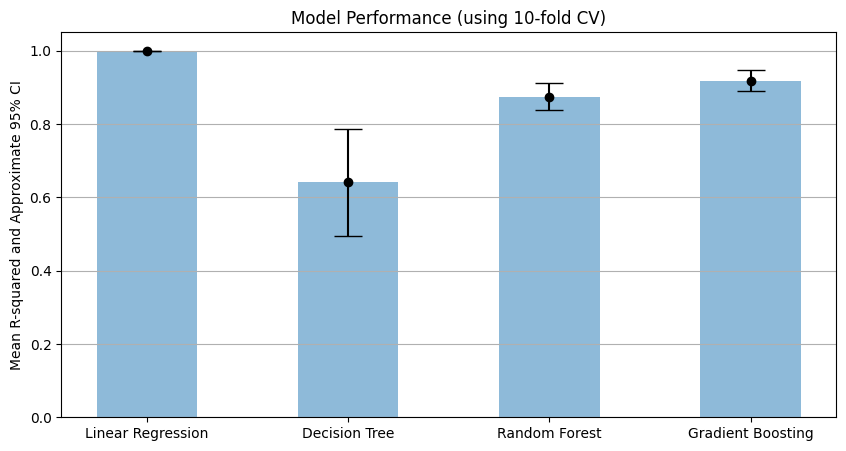

In [281]:
# plot score means and variances on a bar chart with a line for the variance
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
means = [scores_ls.mean(), scores_dt.mean(), scores_rf.mean(), scores_gb.mean()]
stderrors = [scores_ls.std(), scores_dt.std(), scores_rf.std(), scores_gb.std()] / np.sqrt(k)

fig, ax = plt.subplots(figsize=(10, 5))
#ax.bar(models, means, yerr=variances, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(models, means, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.5)
ax.errorbar(models, means, yerr=1.96*stderrors, fmt='o', color='black', ecolor='black', capsize=10)
ax.set_ylabel(f'Mean R-squared and Approximate 95% CI')
ax.set_title(f'Model Performance (using {k}-fold CV)')
ax.yaxis.grid(True)
plt.show()

In [200]:
# Okay, use grid search to find the best hyperparameters for the Gradient Boosting Regressor
param_grid = {
 'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model_ls, param_grid, cv=10, scoring='r2')
grid_search.fit(X, y)

print(f"** Best R2 = {grid_search.best_score_:1.2E} **")
print(f"** Best Parameters = {grid_search.best_params_} **")

** Best R2 = 1.00E+00 **
** Best Parameters = {'fit_intercept': True} **


In [160]:
from google.colab import files
uploaded = files.upload()

Saving Test_Data.xlsx to Test_Data.xlsx


In [201]:
# Loading the file into a data frame
test_df = pd.read_excel('Test_Data.xlsx')
print(test_df)

   Rk  G  Date  Age  Tm  Opp  GS  MP  FG  FGA  ...  DRB  TRB  AST  STL  BLK  \
0   1  1   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
1   2  2   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
2   3  3   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
3   4  4   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
4   5  5   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
5   6  6   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
6   7  7   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   
7   8  8   NaN  NaN NaN  NaN NaN NaN NaN  NaN  ...  NaN  NaN  NaN  NaN  NaN   

   TOV  PF  PTS  GmSc  +/-  
0  NaN NaN  NaN   NaN  NaN  
1  NaN NaN  NaN   NaN  NaN  
2  NaN NaN  NaN   NaN  NaN  
3  NaN NaN  NaN   NaN  NaN  
4  NaN NaN  NaN   NaN  NaN  
5  NaN NaN  NaN   NaN  NaN  
6  NaN NaN  NaN   NaN  NaN  
7  NaN NaN  NaN   NaN  NaN  

[8 rows x 28 columns]


In [202]:
# get a list of the column names that are either integers or floats
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_test_df = test_df.select_dtypes(include=numerics).copy()
numeric_test_df.describe()

,Rk,G,Date,Age,Tm,Opp,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
count,8.00000,8.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,4.50000,4.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.44949,2.44949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.00000,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.75000,2.75000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4.50000,4.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,6.25000,6.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,8.00000,8.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [227]:
X_sub = numeric_test_df.drop(columns=['PTS','Rk']).select_dtypes(include=numerics).copy()

In [229]:
X_train_columns = X_train.columns
X_sub = X_sub.reindex(columns=X_train_columns, fill_value=0)

In [230]:
model_xx = LinearRegression()
model_xx.fit(X_train, y_train)

numeric_test_df = numeric_test_df.drop(columns=['Rk'], errors='ignore')
numeric_test_df['PTS'] = model_xx.predict(X_sub)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [231]:
numeric_test_df[['Rk', 'PTS']].head()

KeyError: "['Rk'] not in index"